In [16]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

%config InlineBackend.figure_format = 'retina'

class MaskedImageDataset(Dataset):
    def __init__(self, base_dataset, mask_ratio=0.75):
        self.base = base_dataset
        self.mask_ratio = mask_ratio

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base[idx]             # ignore label
        mask = torch.rand_like(img[:1]) > self.mask_ratio  # [1,H,W]
        masked_img = img * mask             # zero out masked pixels
        return masked_img, img              # (X=masked, Y=original)


In [32]:
from torchvision import datasets
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

from torch.utils.data import Subset

# full CIFAR10
train_base = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_base  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# take first 1000 samples from each
train_small = Subset(train_base, range(1000))
test_small  = Subset(test_base, range(1000))

# wrap with masking dataset
train_masked = MaskedImageDataset(train_small, mask_ratio=0.75)
test_masked  = MaskedImageDataset(test_small,  mask_ratio=0.75)

# dataloaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_masked, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_masked,  batch_size=16, shuffle=False)

print(len(train_loader.dataset), len(test_loader.dataset))


1000 1000


torch.Size([3, 224, 224]) torch.Size([3, 224, 224])


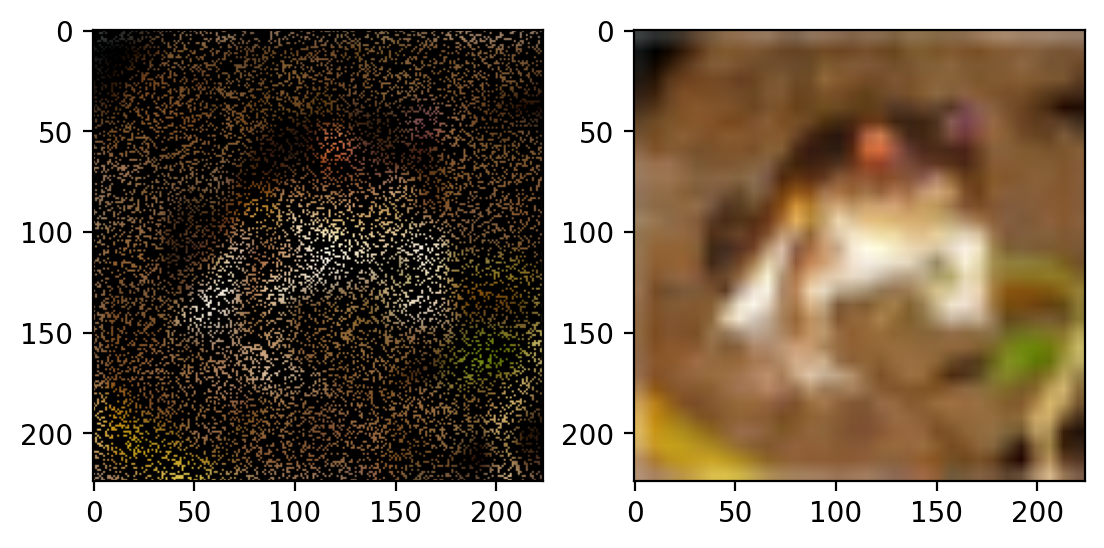

In [33]:
x, y = train_masked[0]
print(x.shape, y.shape)  # both [3,224,224]

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(x.permute(1,2,0))  # masked
plt.subplot(1,2,2)
plt.imshow(y.permute(1,2,0))  # original
plt.show()

In [34]:
import torch.nn as nn

class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 112×112
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 56×56
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),# 28×28
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 56×56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 112×112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),   # 224×224
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [35]:
model = SimpleAutoencoder()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = model.to(device)


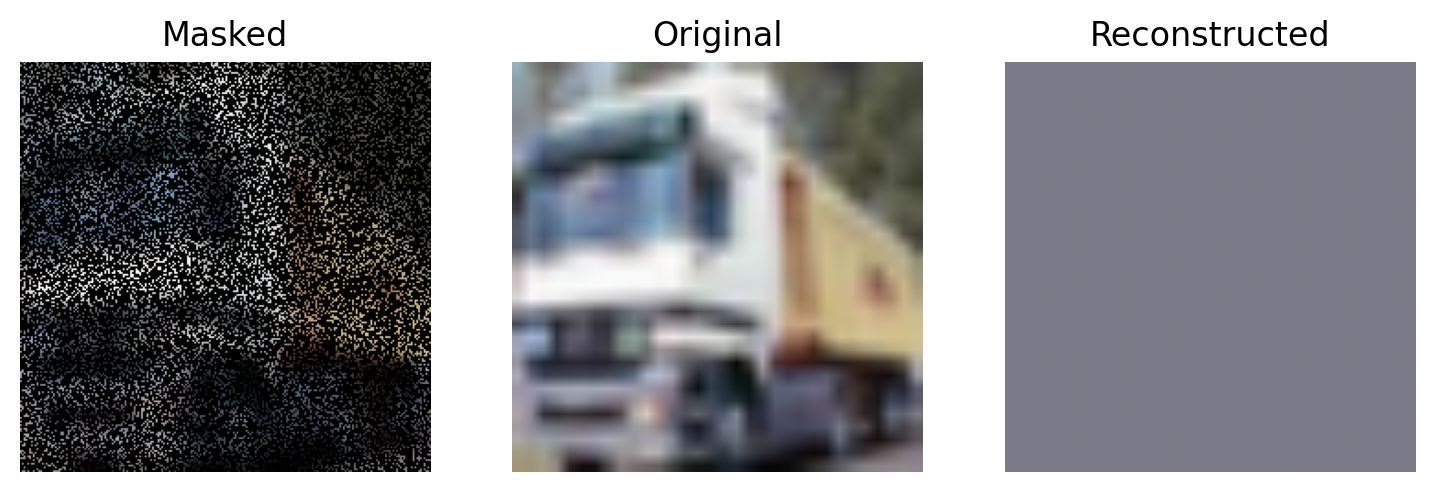

In [39]:
idx = 1
x_masked, y_full = train_masked[idx]   # always the same
x_masked, y_full = x_masked.unsqueeze(0).to(device), y_full.unsqueeze(0).to(device)
with torch.no_grad():
    recon = model(x_masked)

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(x_masked[0].permute(1,2,0).cpu()); plt.title("Masked"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(y_full[0].permute(1,2,0).cpu()); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(recon[0].permute(1,2,0).cpu()); plt.title("Reconstructed"); plt.axis('off')
plt.show()

In [40]:
model = SimpleAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(5):
    model.train()
    total = 0
    for x_masked, y_full in train_loader:
        x_masked, y_full = x_masked.to(device), y_full.to(device)
        pred = model(x_masked)
        loss = criterion(pred, y_full)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total += loss.item() * x_masked.size(0)
    print(f"Epoch {epoch+1}: loss={total/len(train_loader.dataset):.4f}")


Epoch 1: loss=0.0222
Epoch 2: loss=0.0091
Epoch 3: loss=0.0080
Epoch 4: loss=0.0073
Epoch 5: loss=0.0069


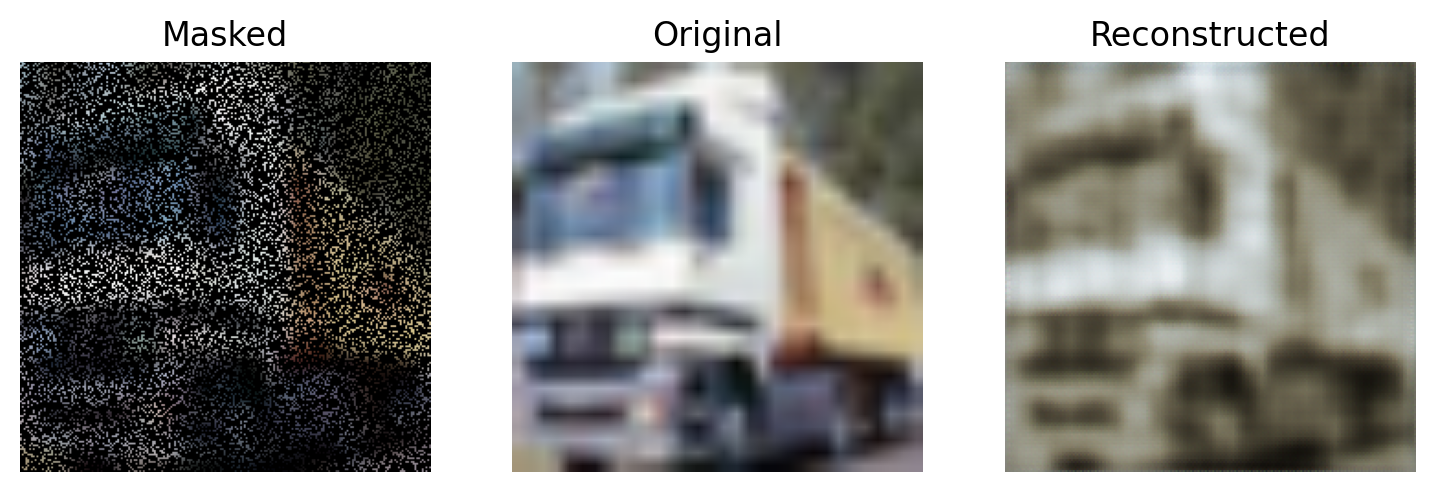

In [41]:
idx = 1
x_masked, y_full = train_masked[idx]   # always the same
x_masked, y_full = x_masked.unsqueeze(0).to(device), y_full.unsqueeze(0).to(device)
with torch.no_grad():
    recon = model(x_masked)

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(x_masked[0].permute(1,2,0).cpu()); plt.title("Masked"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(y_full[0].permute(1,2,0).cpu()); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(recon[0].permute(1,2,0).cpu()); plt.title("Reconstructed"); plt.axis('off')
plt.show()

Now, let us improve the model by adding skip connections like in U-Net.

In [42]:
import torch.nn.functional as F

class SkipAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.enc2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.enc3 = nn.Conv2d(64, 128, 4, 2, 1)

        self.dec3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.dec2 = nn.ConvTranspose2d(64+64, 32, 4, 2, 1)
        self.dec1 = nn.ConvTranspose2d(32+32, 3, 4, 2, 1)

    def forward(self, x):
        x1 = F.relu(self.enc1(x))      # 112x112
        x2 = F.relu(self.enc2(x1))     # 56x56
        x3 = F.relu(self.enc3(x2))     # 28x28
        y3 = F.relu(self.dec3(x3))     # 56x56
        y2 = F.relu(self.dec2(torch.cat([y3, x2], 1)))  # skip
        y1 = torch.sigmoid(self.dec1(torch.cat([y2, x1], 1)))
        return y1


model = SkipAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(5):
    model.train()
    total = 0
    for x_masked, y_full in train_loader:
        x_masked, y_full = x_masked.to(device), y_full.to(device)
        pred = model(x_masked)
        loss = criterion(pred, y_full)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total += loss.item() * x_masked.size(0)
    print(f"Epoch {epoch+1}: loss={total/len(train_loader.dataset):.4f}")

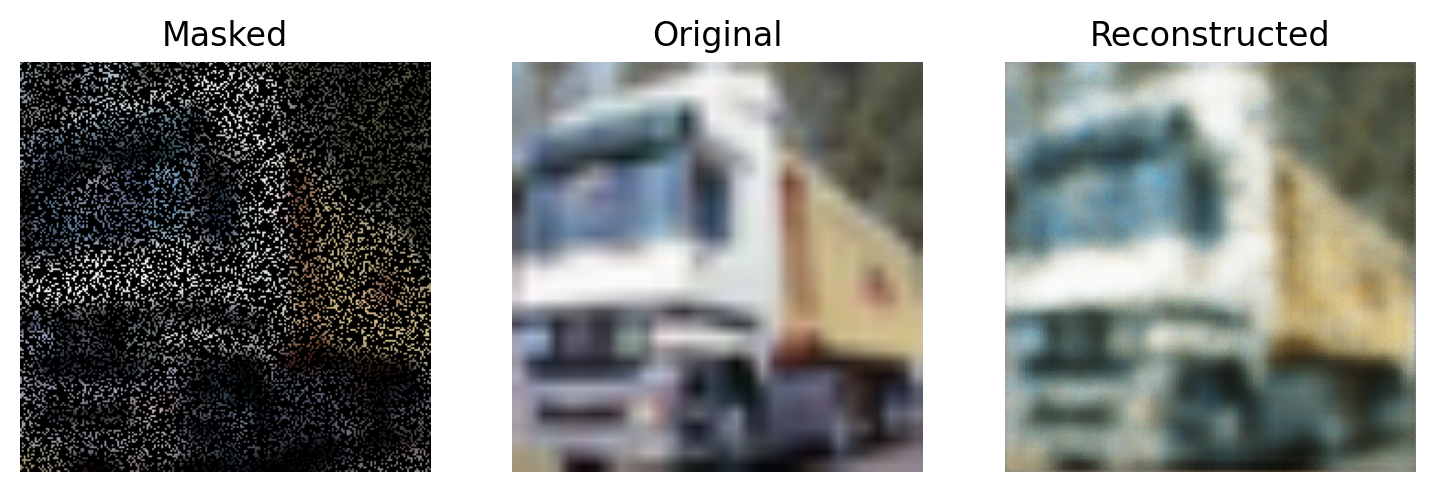

In [44]:
idx = 1
x_masked, y_full = train_masked[idx]   # always the same
x_masked, y_full = x_masked.unsqueeze(0).to(device), y_full.unsqueeze(0).to(device)
with torch.no_grad():
    recon = model(x_masked)

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(x_masked[0].permute(1,2,0).cpu()); plt.title("Masked"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(y_full[0].permute(1,2,0).cpu()); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(recon[0].permute(1,2,0).cpu()); plt.title("Reconstructed"); plt.axis('off')
plt.show()

We can see that the skip connections help a lot in reconstructing the original image from the masked input. The colors match much better and the details are clearer.